卷积神经网络（Convolutional Neural Network，CNN）被用于图像识别、语音识别等各种场合，在图像识别的比赛中，基于深度学习的方法几乎都以CNN为基础

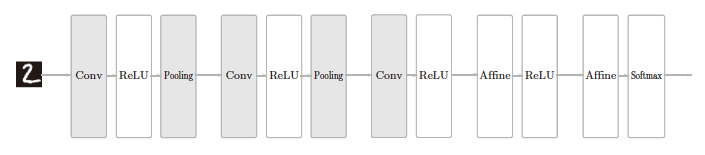

CNN 中新增了Convolution 层和Pooling 层。CNN 的层的连接顺序是"Convolution - ReLU -（Pooling)"

## 卷积操作

卷积运算相当于图像处理中的滤波器运算。对于输入数据，卷积运算以一定间隔滑动滤波器的窗口并应用。将各个位置上滤波器的元素和输入的对应元素相乘，然后再求和（有时将这个计算称为乘积累加运算）。

### 填充 Padding

在进行卷积层的处理之前，有时要向输入数据的周围填入固定的数据（比如0 等），这称为填充（padding）

### 步幅 Stride

应用滤波器的位置间隔称为步幅（stride）

增大步幅Stride后，输出大小会变小。而增大填充Padding后，输出大小会变大。假设输入大小为 $(H, W)$， 滤波器大小为 $(FH, FW)$，输出大小为 $(OH, OW)$，填充为$P$，步幅为$S$，则输出大小和上面参数关系如下：

$$\begin{aligned} O H &=\frac{H+2 P-F H}{S}+1 \\ O W &=\frac{W+2 P-F W}{S}+1 \end{aligned}$$

__note: __ 所设定的值必须上使式中的和分别可以除尽。当输出大小无法除尽时（结果是小数时），需要采取报错等对策

### 三维数据的卷积运算

图像是3维数据，除了高、长方向之外，还需要处理通道方向。通道方向上有多个特征图时，会按每个通道分别进行输入数据和滤波器的卷积运算，并将每个通道结果相加，从而得到输出

**note: ** 在3维数据的卷积运算中，输入数据和滤波器的通道数要设为相同的值。

比如，通道数为$C$、高度为$H$、长度为$W$的数据的形状可以写成$(C,H,W)$。滤波器也一样，要按$(channel, height, width)$的顺序书写。比如，通道数为$C$、滤波器高度为$FH$（Filter Height）、长度为$FW$（Filter Width）时，可以写成$(C, FH, FW)$。

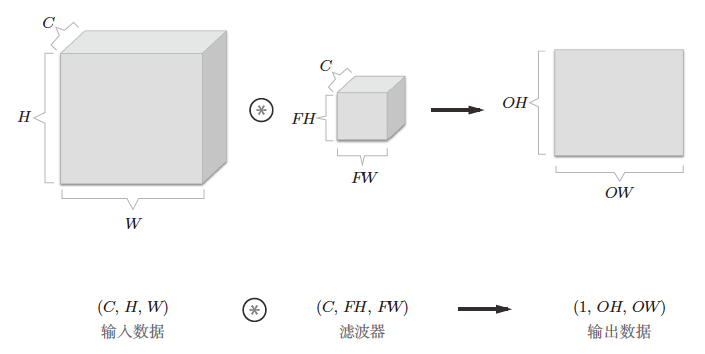

如果要在通道方向上也拥有多个卷积运算的输出，就需要用到多个滤波器（权重）

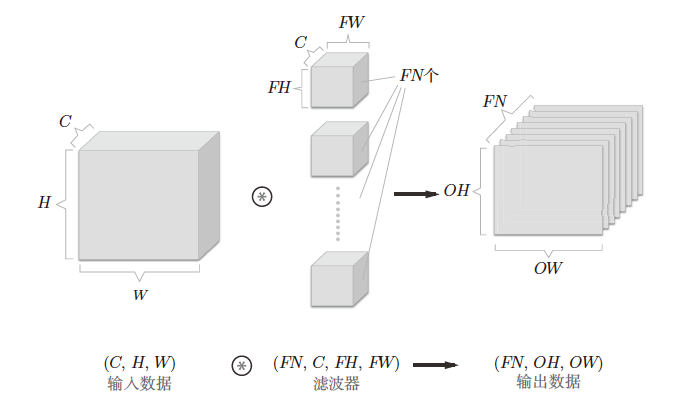

### 批处理的卷积运算

要同时处理N个图片，则需要将在各层间传递的数据保存为四维数据 $(batchNum, channel, height, width)$ 。批处理将N次的处理汇总成了1 次进行

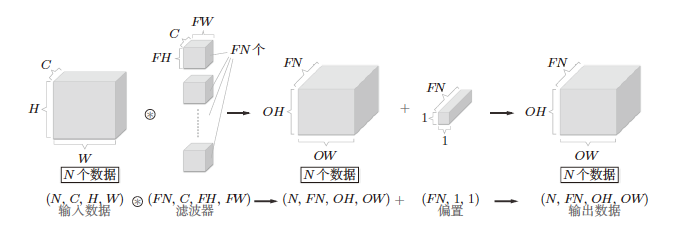

## 池化操作

池化是缩小高、长方向上的空间的运算，可以缩小空间大小

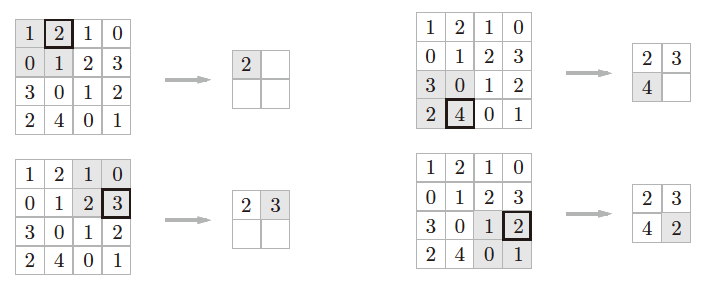

上面例子是按步幅2 进行2 × 2 的Max池化时的处理顺序。“Max池化”是获取最大值的运算(还有Average池化)，“2 × 2”表示目标区域的大小

池化层有以下的特征：

1. 没有要学习的参数。池化只是从目标区域取最大值或者平均值
2. 通道数不发生变化。池化运算是按通道独立运算的
3. 对微小的位置变化具有健壮性。输入数据发生微小偏差时，池化仍然返回相同的结果

## 卷积层的实现

如前所述，CNN中各层间传递的数据是4 维数据。所谓4 维数据，比如数据的形状是(10, 1, 28, 28)，则它对应10 个高为28、长为28、通道为1 的数据

In [1]:
import numpy as np

x = np.random.rand(10, 1, 28, 28) # 随机生成数据
x.shape

(10, 1, 28, 28)

In [5]:
# 访问第一个数据
#x[0]
# 第一个数据的第一个通道的数据
x[0][0].shape

(28, 28)

如果按照循环处理四维数组的方式求卷积，就会很复杂，下面使用基于im2col展开的方式简化

In [7]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : 由(数据量, 通道, 高, 长)的4维数组构成的输入数据
    filter_h : 滤波器的高
    filter_w : 滤波器的长
    stride : 步幅
    pad : 填充

    Returns
    -------
    col : 2维数组
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 输入数据的形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

`im2col`是一个函数，将输入数据展开以适合滤波器（权重）。对3 维的输入数据应用`im2col`后，数据转换为2 维矩阵（正确地讲，是把包含批数量的4 维数据转换成了2 维数据）。对于输入数据，将应用滤波器的区域（3 维方块）横向展开为1 列

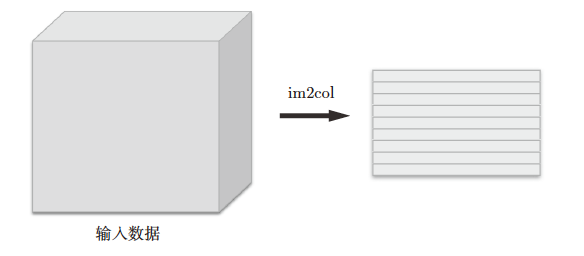

在实际的卷积运算中，滤波器的应用区域几乎都是重叠的。在滤波器的应用区域重叠的情况下，使用`im2col`展开后，展开后的元素个数会多于原方块的元素个数。因此，使用`im2col`的实现存在比普通的实现消耗更多内存的缺点。

将输入数据通过`im2col`展开为二维数据后，再将滤波器纵向展开，然后再计算两个矩阵的乘积，最后根据输出数据的形状将二维中间结果转换为输出数据的形状

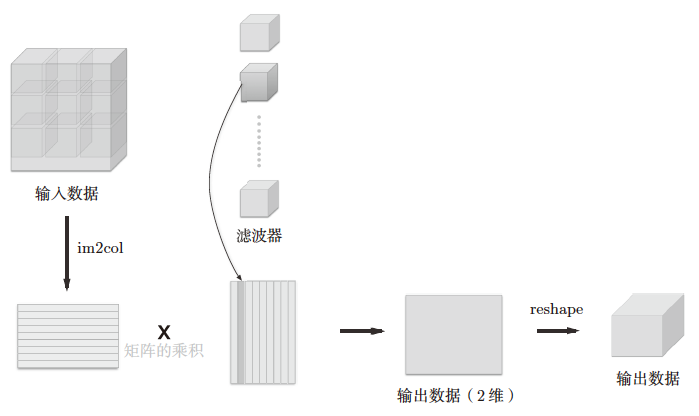

`im2col` 函数具有以下接口

im2col (input_data, filter_h, filter_w, stride=1, pad=0)

- input_data―由（数据量，通道，高，长）的4维数组构成的输入数据
- filter_h―滤波器的高
- filter_w―滤波器的长
- stride―步幅
- pad―填充

In [7]:
x1 = np.random.rand(1, 3, 7, 7) # 批大小为1、通道为3的7X7的数据
col1 = im2col(x1, 5, 5, stride=1, pad=0) # 
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7) # 批大小为10
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


滤波器是(FN, C, FH, FW) 的4 维形状，分别是Filter Number（滤波器数量）、Channel、Filter Height、Filter Width 的缩写

在进行卷积层的反向传播时，必须进行`im2col`的逆处理。这可以`col2im`函数，卷积层的反向传播和Affine 层的实现方式一样 （矩阵乘法运算的反向传播）

`col2im` 函数具有以下接口

col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0)

- col
- input_shape―由（数据量，通道，高，长）的4维数组构成的输入数据
- filter_h―滤波器的高
- filter_w―滤波器的长
- stride―步幅
- pad―填充

In [3]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中间数据（backward时使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 权重和偏置参数的梯度
        self.dW = None
        self.db = None
    
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        # 计算出输出数据的形状
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad) # 展开输入数据
        col_W = self.W.reshape(FN, -1).T # 滤波器的展开
        out = np.dot(col, col_W) + self.b
        
        # 转换为输出形状
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) #?
        
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out

#    # Affine层的反向传播
#    def backward(self, dout):
#        dx = np.dot(dout, self.W.T)
#        self.dW = np.dot(self.x.T, dout)
#        self.db = np.sum(dout, axis=0)
#        
#        return dx
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        return dx

## 池化层的实现

池化层的实现和卷积层相同，都使用`im2col`展开输入数据。不过，池化的情况下，在通道方向上是独立的，池化的应用区域按通道单独展开。这样展开之后，只需对展开的矩阵求各行的最大值，并转换为合适的形状即可

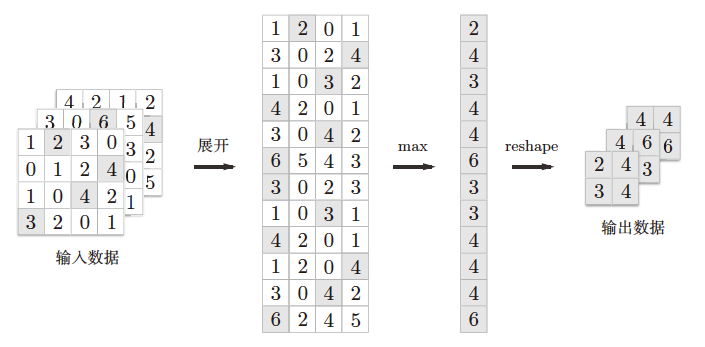

In [4]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        
        # 输出数据的形状
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        # 展开(1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        # 最大值(2)
        out = np.max(col, axis=1)
        arg_max = np.argmax(col, axis=1)
        # 转换(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        self.x = x
        self.arg_max = arg_max
        
        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

## CNN的实现

简单CNN网络的构成是“Convolution - ReLU - Pooling -Affine - ReLU - Affine - Softmax”，实现为名为SimpleConvNet的类。

In [5]:
import sys, os
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """简单的ConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 输入大小（MNIST的情况下为784）
    hidden_size_list : 隐藏层的神经元数量的列表（e.g. [100, 100, 100]）
    output_size : 输出大小（MNIST的情况下为10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 指定权重的标准差（e.g. 0.01）
        指定'relu'或'he'的情况下设定“He的初始值”
        指定'sigmoid'或'xavier'的情况下设定“Xavier的初始值”
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = ReLU()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """求损失函数
        参数x是输入数据、t是教师标签
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """求梯度（数值微分）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重
            grads['b1']、grads['b2']、...是各层的偏置
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """求梯度（误差反向传播法）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重
            grads['b1']、grads['b2']、...是各层的偏置
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

## 训练CNN

train loss:2.3002621032871726
=== epoch:1, train acc:0.192, test acc:0.232 ===
train loss:2.2969807808472726
train loss:2.296037963996323
train loss:2.2867364847256293
train loss:2.281591894526612
train loss:2.267683467153399
train loss:2.2566802573172557
train loss:2.2219079386191907
train loss:2.2356170707636043
train loss:2.1760557202246376
train loss:2.1664391858152516
train loss:2.1713468547163925
train loss:2.0677675724724374
train loss:2.0007735157672344
train loss:2.0339443032073907
train loss:1.9446295389565362
train loss:1.8527156117976515
train loss:1.7722916085924671
train loss:1.6162366699920676
train loss:1.5913971788400847
train loss:1.529668054023052
train loss:1.5374169910830568
train loss:1.4232885520898544
train loss:1.3073687172235144
train loss:1.25961571071988
train loss:1.15957381053283
train loss:1.1457530056664917
train loss:0.9659446384940428
train loss:0.9419885598668338
train loss:0.9246445658761231
train loss:0.9047610154507517
train loss:0.7053889827166432

train loss:0.276676251504726
train loss:0.15422858292937533
train loss:0.2698263393298019
train loss:0.13087642619434584
train loss:0.2098044466204017
train loss:0.41766802218827365
train loss:0.2946162671598225
train loss:0.24209516720274732
train loss:0.1973349049027886
train loss:0.2467621315601965
train loss:0.17737750143510234
train loss:0.16271212042774635
train loss:0.36684421873747936
train loss:0.2645108413106486
train loss:0.5052026218695205
train loss:0.28120251692739445
train loss:0.3614436452421974
train loss:0.21956158012473598
train loss:0.1767656139363192
train loss:0.2293720562492885
train loss:0.2641938291875246
train loss:0.2755775502879247
train loss:0.21832624022004346
train loss:0.1962194756266843
train loss:0.13809842526804625
train loss:0.29031806666796245
train loss:0.19425065770361247
train loss:0.29692373587448007
train loss:0.18490745296998606
train loss:0.2171226739700794
train loss:0.20642653858932014
train loss:0.09617364004041745
train loss:0.40006321892

train loss:0.16486934174252915
train loss:0.124358500999764
train loss:0.10092011222181498
train loss:0.06745021758153215
train loss:0.1251687211853619
train loss:0.09135996127789311
train loss:0.13885576875673236
train loss:0.11422322174766056
train loss:0.07068977413469506
train loss:0.1146709646269745
train loss:0.11249375576243839
train loss:0.10513904946508795
train loss:0.13817509126264726
train loss:0.08934057743011667
train loss:0.138844787130766
train loss:0.0902600127436583
train loss:0.07152175428328823
train loss:0.13960767567847715
train loss:0.07511419278594202
train loss:0.1896483522888752
train loss:0.2134496422828223
train loss:0.10106796217389111
train loss:0.17855642050294496
train loss:0.15197492339874838
train loss:0.21952693340584906
train loss:0.10523815509976227
train loss:0.04830567634781933
train loss:0.1876293852742786
train loss:0.1835759609739611
train loss:0.13339113136587646
train loss:0.11041681910830783
train loss:0.0960100716312866
train loss:0.0588688

train loss:0.06849866763401499
train loss:0.04532028020083567
train loss:0.17978005103540304
train loss:0.066202066129354
train loss:0.08389869928975317
train loss:0.12680662323608935
train loss:0.09841571882985631
train loss:0.1053987714798962
train loss:0.1438021091557451
train loss:0.1342827672495042
train loss:0.13679003327852832
train loss:0.0811675209660382
train loss:0.06029525139612875
train loss:0.2466566390641699
train loss:0.11557948211755605
train loss:0.0972021344668108
train loss:0.05421307414114711
train loss:0.10091551122555685
train loss:0.049791933163993045
train loss:0.030185203856908795
train loss:0.04175776197725997
train loss:0.1038034236277462
train loss:0.10372730757116985
train loss:0.08268137510215766
train loss:0.07969149876788267
train loss:0.052630126118646085
train loss:0.10474025385360596
train loss:0.041865976934331924
train loss:0.11592308909488092
train loss:0.07498482839982619
train loss:0.047670763141084684
train loss:0.058474179880385606
train loss:

train loss:0.03364402384554122
train loss:0.10334224383104579
train loss:0.05823950793526441
train loss:0.09078886117069461
train loss:0.05492978132698118
train loss:0.14696692414907506
train loss:0.08588797996834577
train loss:0.06395416183447197
train loss:0.11134883869147813
train loss:0.035122844881773516
train loss:0.0493118023458119
train loss:0.03931804909424042
train loss:0.035544397014774055
train loss:0.03689804462051239
train loss:0.07211036374293814
train loss:0.04067581297856862
train loss:0.18913483730969072
train loss:0.1312966958690621
train loss:0.048629168710923716
train loss:0.171007679500151
train loss:0.057309273841609026
train loss:0.14788690962914697
train loss:0.0764559305098327
train loss:0.09686090933407092
train loss:0.06546333582857562
train loss:0.162913054934833
train loss:0.04845575992041764
train loss:0.06353457373425747
train loss:0.059961566888250016
train loss:0.0351653971580394
train loss:0.08554397677891144
train loss:0.016053249555600092
train loss

train loss:0.04871877043277064
train loss:0.03736584755432901
train loss:0.039021250472314646
train loss:0.043825638128707746
train loss:0.10989431386354288
train loss:0.0515749009391962
train loss:0.04507921214536287
train loss:0.03886505129264309
train loss:0.055688204576665415
train loss:0.05360916349505251
train loss:0.06214130739430803
train loss:0.05872198313285008
train loss:0.025413173310387914
train loss:0.1672652793298429
train loss:0.03276045291260109
train loss:0.0326240193948509
train loss:0.029815212167077953
train loss:0.058916742982215616
train loss:0.013916773446934596
train loss:0.027558746884406054
train loss:0.08750351047699084
train loss:0.02209966803706679
train loss:0.11040888474804088
train loss:0.014784870365224974
train loss:0.1551131106503938
train loss:0.029717968959445135
train loss:0.018855314850938183
train loss:0.07100703337772592
train loss:0.035150434940181156
train loss:0.12204060848933446
train loss:0.09633300166370015
train loss:0.02413520303325569


train loss:0.06694550145648208
train loss:0.021022895008919892
train loss:0.03215320347520021
train loss:0.05842414927023502
train loss:0.0067900174839554
train loss:0.05295509625359875
train loss:0.01671204003647114
train loss:0.03423306243275273
train loss:0.11255166360972266
train loss:0.06994424162536324
train loss:0.03614082704916897
train loss:0.05353876854154001
train loss:0.051817691531125025
train loss:0.07464732075901287
train loss:0.020048743874309646
train loss:0.01823252806331267
train loss:0.005289462204764116
train loss:0.040122818694315755
train loss:0.009851490151122829
train loss:0.06420630684148508
train loss:0.05573072401584369
train loss:0.02168142672120924
train loss:0.022334611699271485
train loss:0.01823976896215324
train loss:0.017799700875273824
train loss:0.11098871499331242
train loss:0.08933273238200944
train loss:0.08279947551479068
train loss:0.05137826196411106
train loss:0.014404066831438895
train loss:0.09271150460077685
train loss:0.0331843882409964
t

train loss:0.0939046576700449
train loss:0.016562249917293152
train loss:0.07206648562711368
train loss:0.03183843262648936
train loss:0.013266235306647237
train loss:0.014098468227198298
train loss:0.026315941723792858
train loss:0.020538788899173453
train loss:0.018692880032442013
train loss:0.023577883364571766
train loss:0.04811124308563163
train loss:0.03820592464873468
train loss:0.017611039747166397
train loss:0.04362855108477797
train loss:0.04261432542042686
train loss:0.028614510207616226
train loss:0.010677900397302341
train loss:0.056890928507605805
train loss:0.05733651695239203
train loss:0.043121825908818676
train loss:0.04504079696379018
train loss:0.07260208211768122
train loss:0.05217002583027099
train loss:0.018089899566241706
train loss:0.028426501134801323
train loss:0.009574839607804865
train loss:0.0289536373435041
train loss:0.0543527510624702
train loss:0.04776762812789168
train loss:0.0675526721631705
train loss:0.013281672298976423
train loss:0.08245198227372

train loss:0.012530048570875738
train loss:0.03275419884431138
train loss:0.009153486533946407
train loss:0.01286160848406934
train loss:0.0264827842853969
train loss:0.01988917240599768
train loss:0.04257745472159498
train loss:0.008739874666798509
train loss:0.02096768001889273
train loss:0.022962130774173348
train loss:0.04242423804720345
train loss:0.012157810428188618
train loss:0.017317225910645207
train loss:0.09355069806375577
train loss:0.03282319518166845
train loss:0.0096920275673341
train loss:0.03458551208146977
train loss:0.009035909049993773
train loss:0.013777943614290269
train loss:0.029641635349498693
train loss:0.02944155052247528
train loss:0.050214988589671966
train loss:0.0422569773862687
train loss:0.06464494877719001
train loss:0.021736679126826162
train loss:0.01959252572182685
train loss:0.0706614638658343
train loss:0.010485663609905221
train loss:0.03252943282941425
train loss:0.03735019996339576
train loss:0.024412647817304
train loss:0.019938040703041598
t

train loss:0.09170849493506145
train loss:0.008248728548036925
train loss:0.020349633711218132
train loss:0.017625484956995355
train loss:0.1121399793004248
train loss:0.04775841620450525
train loss:0.006815720302733892
train loss:0.027378822728573535
train loss:0.009814554415924694
train loss:0.03755236059519033
train loss:0.05075589943720147
train loss:0.015469683590029308
train loss:0.013550945070615984
train loss:0.008286653917010618
train loss:0.01289648970593648
train loss:0.01508044282048526
train loss:0.025886565311034188
train loss:0.012324129708166414
train loss:0.02794715662640866
train loss:0.04471571972375063
train loss:0.00867417914006172
=== epoch:5, train acc:0.985, test acc:0.982 ===
train loss:0.013545715194415449
train loss:0.05147990715728471
train loss:0.003721962265319293
train loss:0.052611669298986
train loss:0.019517584478364138
train loss:0.030640896706965157
train loss:0.008017128395711311
train loss:0.034110574049065166
train loss:0.022625152828407633
train 

train loss:0.003773003147127542
train loss:0.005082311579673839
train loss:0.00668360584234162
train loss:0.030634293756690977
train loss:0.007306941925534794
train loss:0.013772014539342237
train loss:0.03824943443124049
train loss:0.07221135381195441
train loss:0.025864517841401643
train loss:0.007920998199773184
train loss:0.01275819888919241
train loss:0.07766957004433137
train loss:0.012372453330024435
train loss:0.008101558729862098
train loss:0.02250683135809828
train loss:0.023566102464474614
train loss:0.010387830159404983
train loss:0.05430593669636461
train loss:0.010819295702900909
train loss:0.01050822148641227
train loss:0.04665601826731347
train loss:0.04814952277204254
train loss:0.008453085837665528
train loss:0.004832066306187385
train loss:0.011946222540424272
train loss:0.022569710300745113
train loss:0.006049485844551521
train loss:0.08007716964164273
train loss:0.05387771231346644
train loss:0.06486139432988702
train loss:0.0028470822278673005
train loss:0.0059431

train loss:0.02288398349891295
train loss:0.017359724638371706
train loss:0.020540079206851886
train loss:0.0068320903493791305
train loss:0.016762032483972
train loss:0.07448085307756068
train loss:0.014985239873603557
train loss:0.013697613177893036
train loss:0.003685986339153029
train loss:0.014934118442909403
train loss:0.005370940951474175
train loss:0.02250429445212245
train loss:0.051336753350958414
train loss:0.006241762466186671
train loss:0.019758600817501474
train loss:0.006075173205368553
train loss:0.017222623239465776
train loss:0.007552889711370822
train loss:0.00783017861854289
train loss:0.021012811123470677
train loss:0.015177134977165338
train loss:0.0075225599595975965
train loss:0.01879736515836803
train loss:0.004097060589582539
train loss:0.011423839584678458
train loss:0.03185408823643853
train loss:0.057183260154342205
train loss:0.009509442330733791
train loss:0.1739329267895048
train loss:0.013873583346657758
train loss:0.011136988334886582
train loss:0.0759

train loss:0.022198840648399228
train loss:0.023950001696921852
train loss:0.02999504977587156
train loss:0.011849675974275933
train loss:0.04998679661487265
train loss:0.06321798382652825
train loss:0.021059717932315213
train loss:0.011050071996281753
train loss:0.05267553864007815
train loss:0.035282775812874305
train loss:0.04791116482982623
train loss:0.04492704488682105
train loss:0.010757215547278414
train loss:0.004726411808503565
train loss:0.008422311034244638
train loss:0.08443875564892565
train loss:0.023417823597019823
train loss:0.051098542615585114
train loss:0.03322356198687802
train loss:0.026039904430733816
train loss:0.010643194610005968
train loss:0.009888465890085274
train loss:0.013716527743501024
train loss:0.008964358835879723
train loss:0.012480579650275849
train loss:0.08267860566139619
train loss:0.015954113537724805
train loss:0.008229638702752187
train loss:0.026602217056295233
train loss:0.027494542795677947
train loss:0.023294180901925497
train loss:0.0288

train loss:0.013680248119224548
train loss:0.005278287101164018
train loss:0.046165426364047725
train loss:0.023594842695501342
train loss:0.014183694269374133
train loss:0.01954739928196219
train loss:0.0026126801191152025
train loss:0.021221397656480664
train loss:0.005761227214002541
train loss:0.011050977161711687
train loss:0.009592189157635964
train loss:0.002659042952657278
train loss:0.006490333036057192
train loss:0.004550998295697863
train loss:0.0029376552474355212
train loss:0.006571476009580709
train loss:0.02003886877632628
train loss:0.026065579534789714
train loss:0.015840064848931693
train loss:0.09219136005012774
train loss:0.012890064199590587
train loss:0.002033189155601383
train loss:0.005161741303885023
train loss:0.008217230769204468
train loss:0.005331100789418751
train loss:0.012016421575160903
train loss:0.09655267234703928
train loss:0.07932036342034776
train loss:0.005766515898192254
train loss:0.013428447977313223
train loss:0.05121373823198464
train loss:0

train loss:0.023685697822379885
train loss:0.011203509185395541
train loss:0.016733007088090335
train loss:0.0038234170218784287
train loss:0.026494191999639146
train loss:0.027374079198702203
train loss:0.010782771320018907
train loss:0.007513791498178117
train loss:0.00947591240404508
train loss:0.006207427909862908
train loss:0.049945816738477575
train loss:0.03179109651769414
train loss:0.007235851827679347
train loss:0.0074436236404051784
train loss:0.002036908981342759
train loss:0.01433157924764178
train loss:0.014542354183207228
train loss:0.005219601335745627
train loss:0.007189942770100628
train loss:0.015196410847683466
train loss:0.014846485170972505
train loss:0.01621912863915152
train loss:0.009508640931016745
train loss:0.009240185266033393
train loss:0.0264523447436425
train loss:0.015675075204656618
train loss:0.021938733970133514
train loss:0.016179279605588466
train loss:0.004944403353365818
train loss:0.008799301376316397
train loss:0.0264821495566588
train loss:0.0

train loss:0.0018397286993646017
train loss:0.03097490223695717
train loss:0.016234940538468915
train loss:0.007575369547297205
train loss:0.010010503777874564
train loss:0.06183571686694665
train loss:0.008757219770230308
train loss:0.009145031076341695
train loss:0.008952133387654848
train loss:0.010200019455906501
train loss:0.00927503426387252
train loss:0.036222332358765714
train loss:0.031627692336177717
train loss:0.029843720667016654
train loss:0.004505828303617
train loss:0.017976641475098858
train loss:0.02118708878565139
train loss:0.01958752377194541
train loss:0.032374298228174905
train loss:0.011334137588086948
train loss:0.003190840832353117
train loss:0.0025449275886158724
train loss:0.0032747097454189173
train loss:0.006760114852657102
train loss:0.031688747243436684
train loss:0.005043938253996941
train loss:0.007651295143332919
train loss:0.009713402727108187
train loss:0.003903784459922697
train loss:0.017155741063617957
train loss:0.018055716515814352
train loss:0.

train loss:0.009576646351267577
train loss:0.047305886860233425
train loss:0.0021886280270976667
train loss:0.009821687107121968
train loss:0.0031699257624449168
train loss:0.004556594791168553
train loss:0.02207662121045839
train loss:0.02266218693526396
train loss:0.006853520477358277
train loss:0.06147741071057049
train loss:0.005073669484169836
train loss:0.007420944873857972
train loss:0.004349800408965948
=== epoch:8, train acc:0.988, test acc:0.987 ===
train loss:0.012930939159848515
train loss:0.003638446703663875
train loss:0.019002755417934877
train loss:0.015882404506737918
train loss:0.02356199529890398
train loss:0.005762666784114789
train loss:0.007597391567669665
train loss:0.049518654037693885
train loss:0.00903265226411482
train loss:0.004038478849485852
train loss:0.006285245684234716
train loss:0.0006057228393269164
train loss:0.01683654152441224
train loss:0.026413038351507018
train loss:0.0037208025187332365
train loss:0.009496257133656665
train loss:0.027472154615

train loss:0.0014847356902762713
train loss:0.00710392854486163
train loss:0.0010579147921928288
train loss:0.005708013179507035
train loss:0.02982651702871316
train loss:0.0026961389038442007
train loss:0.00210323788439065
train loss:0.006816844190974446
train loss:0.008883400133828146
train loss:0.022873284163357894
train loss:0.008288598667155467
train loss:0.007188291743292223
train loss:0.002742446228789987
train loss:0.0036634468098483176
train loss:0.004248737030902142
train loss:0.019180096075943124
train loss:0.013149171460016693
train loss:0.005254212615128817
train loss:0.017023544648203635
train loss:0.0014518495452730627
train loss:0.006092082153621435
train loss:0.002864359775058709
train loss:0.027966897615969467
train loss:0.013280608441753139
train loss:0.04087914263171247
train loss:0.006339844466916878
train loss:0.005749551375328139
train loss:0.015964794508333328
train loss:0.003511008030251734
train loss:0.053971541124146725
train loss:0.005957821991722931
train l

train loss:0.007826119556118767
train loss:0.007970408603097116
train loss:0.02325468018758538
train loss:0.0038632194364897738
train loss:0.00990797299843257
train loss:0.017238903993674008
train loss:0.010053038897071964
train loss:0.015922565936079113
train loss:0.01310955523777218
train loss:0.01980889884037817
train loss:0.0041389679018301526
train loss:0.003992987023531041
train loss:0.05961575470559595
train loss:0.010050193119532414
train loss:0.002514472530784288
train loss:0.0029397342370538725
train loss:0.006119670735719913
train loss:0.0033572858001823026
train loss:0.001526123372706617
train loss:0.0022274956739767927
train loss:0.005618885470621437
train loss:0.01648362872158214
train loss:0.03992439319361816
train loss:0.0034686000857189958
train loss:0.004705983625957056
train loss:0.0031708363798876394
train loss:0.01651635865301567
train loss:0.0038770469659697064
train loss:0.002252200307013091
train loss:0.009244789627765825
train loss:0.0553955370612815
train loss

train loss:0.002021248171240189
train loss:0.005013586041382021
train loss:0.008906235136209927
train loss:0.017805782288488694
train loss:0.0016661846208763417
train loss:0.006430009237210352
train loss:0.005912831258833695
train loss:0.0216135067255255
train loss:0.001967908860009275
train loss:0.004105712559147392
train loss:0.003414076674049843
train loss:0.022597799398008978
train loss:0.005575143474008405
train loss:0.010050013365421833
train loss:0.01169691556193242
train loss:0.00956920893627205
train loss:0.013202674766507947
train loss:0.012583118343507378
train loss:0.0028072260385978358
train loss:0.002570661841611545
train loss:0.004939583936011755
train loss:0.002269623484575869
train loss:0.006076321383756956
train loss:0.003122946563085359
train loss:0.015848709302249936
train loss:0.00788298647224427
train loss:0.004780753222479437
train loss:0.007637722115100856
train loss:0.030953063493672127
train loss:0.01374525869164088
train loss:0.005690630726039001
train loss:0

train loss:0.02430976870709793
train loss:0.011410311609319051
train loss:0.007704630230816482
train loss:0.004290406965470562
train loss:0.004203014430326415
train loss:0.008569605394228396
train loss:0.003144011824964466
train loss:0.013120747654250618
train loss:0.014610068315428488
train loss:0.009817504832981777
train loss:0.004191605617715883
train loss:0.00414824190412514
train loss:0.03094740549877946
train loss:0.015006089061028703
train loss:0.003387388448268166
train loss:0.008262244256470373
train loss:0.0015934216242979571
train loss:0.008667455529594826
train loss:0.029818700719232427
train loss:0.03885315175407453
train loss:0.007803121911544698
train loss:0.011750537953865561
train loss:0.0073627214869479915
train loss:0.005606394556778177
train loss:0.017586379919292988
train loss:0.040262440704956645
train loss:0.006090751453396214
train loss:0.012821496733020245
train loss:0.05547107731626915
train loss:0.012883858936511495
train loss:0.0011350085138512028
train loss

train loss:0.005515891965032533
train loss:0.04311612785235754
train loss:0.01943491039378426
train loss:0.004543919666163884
train loss:0.0026665323395930617
train loss:0.006679355961231032
train loss:0.006696211070343181
train loss:0.00758169792254264
train loss:0.0030442548054767267
train loss:0.0022521348775317316
train loss:0.001023980543065135
train loss:0.0032452436511957892
train loss:0.009068693666061237
train loss:0.005798103157502787
train loss:0.0023382857610325185
train loss:0.006132943465725864
train loss:0.014473763715988701
train loss:0.003107991657165166
train loss:0.0051169683111002996
train loss:0.0035394780605185468
train loss:0.013637147791262292
train loss:0.004430231693657452
train loss:0.00899768165265925
train loss:0.04172448637435898
train loss:0.0029900526910516807
train loss:0.008406621142001552
train loss:0.003368216571646694
train loss:0.005053944386614967
train loss:0.04459996631261654
train loss:0.0014727511417136144
train loss:0.006899575934165097
train

train loss:0.0027663091891460875
train loss:0.006356243934953983
train loss:0.01589684754401866
train loss:0.00545342253347601
train loss:0.004339924983923952
train loss:0.005996737034609479
train loss:0.0072242883227001805
train loss:0.0004825284496550504
train loss:0.007752711279567879
train loss:0.031199319057451717
train loss:0.011754603681371266
train loss:0.0028812129109147783
train loss:0.025400181314908968
train loss:0.0010206970060650754
train loss:0.017737621301098315
train loss:0.003206632943825326
train loss:0.0011807391345584983
train loss:0.003974768716654309
train loss:0.003640198453816684
train loss:0.002567451393359827
train loss:0.018180920445986556
train loss:0.0013770732143620612
train loss:0.0026879404833558725
train loss:0.0014767622746523718
train loss:0.006403667780368408
train loss:0.002263000310925729
train loss:0.001637510442944665
train loss:0.015335651535315811
train loss:0.0030772191996404547
train loss:0.011953376980615063
train loss:0.0018117545987598133

train loss:0.011461914840057357
train loss:0.000334371556401718
train loss:0.003169358365934642
train loss:0.0008958713074422315
train loss:0.002892000404010141
train loss:0.002618462331938384
train loss:0.023031472632089517
train loss:0.0004845001891068332
train loss:0.004527399746375502
train loss:0.011343583679991973
train loss:0.004702704319409767
train loss:0.004950818309019369
train loss:0.0009121949824550895
train loss:0.0003928787143424692
train loss:0.006225462381685307
train loss:0.04920140540993911
train loss:0.0031934277103691034
train loss:0.005388903484170788
train loss:0.0005488509070483883
train loss:0.018846550111232655
train loss:0.004821007187821666
=== epoch:11, train acc:0.991, test acc:0.99 ===
train loss:0.0446693704334196
train loss:0.021920953189812277
train loss:0.007198130862446758
train loss:0.014300014020529168
train loss:0.008336910103563005
train loss:0.0002455804443363335
train loss:0.0017499413498592825
train loss:0.004821960327891174
train loss:0.01427

train loss:0.002509490384352559
train loss:0.07898464051686709
train loss:0.00840329317090986
train loss:0.0026368371072832313
train loss:0.003649987809824697
train loss:0.009024746871115884
train loss:0.0019389603496339717
train loss:0.009013671113065981
train loss:0.0003562257461702076
train loss:0.0011153651138971802
train loss:0.0007279657311269298
train loss:0.0013361067920709018
train loss:0.00523304006385002
train loss:0.006072985329533928
train loss:0.0006386837681417478
train loss:0.037271330231562094
train loss:0.0015509448571854158
train loss:0.00355924746652112
train loss:0.000364989888729326
train loss:0.01075121358429998
train loss:0.005857173648351014
train loss:0.0011929182792674835
train loss:0.00575500925603858
train loss:0.002963753232212225
train loss:0.0004904435524111319
train loss:0.002771639012669179
train loss:0.0070503711306022
train loss:0.0008624900297055158
train loss:0.009196598938588875
train loss:0.00046706187925135353
train loss:0.003329213003870835
tra

train loss:0.03966949859134291
train loss:0.001418484425326004
train loss:0.0010201671736684529
train loss:0.0022521817913344314
train loss:0.0012423865619824157
train loss:0.0028537464475651758
train loss:0.00820325457576661
train loss:0.017908867356599887
train loss:0.0021479505072320177
train loss:0.007319864648263023
train loss:0.007489099362109777
train loss:0.0004704475909033188
train loss:0.0053656870839078295
train loss:0.0004047192951698291
train loss:0.0008816680736732997
train loss:0.0019894880628268897
train loss:0.007087854051268174
train loss:0.012067738483939812
train loss:0.019477098021591418
train loss:0.0007174642933917276
train loss:0.0034496444974334117
train loss:0.007323903820466879
train loss:0.0009647858423915333
train loss:0.0022128703734398845
train loss:0.0025086102584464783
train loss:0.05702091211280104
train loss:0.0030416449729644894
train loss:0.0008847349965857966
train loss:0.004449322169864849
train loss:0.006917961539638561
train loss:0.0010869429977

train loss:0.0022983388669164067
train loss:0.0045956426067735616
train loss:0.0010797583408956256
train loss:0.002439634703868538
train loss:0.015596488348115316
train loss:0.011305142068960985
train loss:0.008205900510415138
train loss:0.014300852667233981
train loss:0.007511233559599539
train loss:0.005540891298585184
train loss:0.006335985027375191
train loss:0.0064340111922917
train loss:0.0010291805922172908
train loss:0.0017075242095758833
train loss:0.004351217521600672
train loss:0.0011349354350275816
train loss:0.0018715438933500997
train loss:0.005735022074841539
train loss:0.009268967962797924
train loss:0.001980698870424763
train loss:0.0007955880914160904
train loss:0.0031391571809699526
train loss:0.0007317363141938003
train loss:0.0024572723814195656
train loss:0.001635875623235373
train loss:0.012374511369235867
train loss:0.003879855580082686
train loss:0.0014743577306668245
train loss:0.0007683295415194976
train loss:0.004897385696962625
train loss:0.0034032605470593

train loss:0.02560748293870224
train loss:0.005797878124858888
train loss:0.024120642331330263
train loss:0.0026181476333814986
train loss:0.01081338925610803
train loss:0.0012619711891075083
train loss:0.023687442448322896
train loss:0.0010885509680345503
train loss:0.0006954283397504038
train loss:0.0012738021682202677
train loss:0.003704330254391423
train loss:0.0031138647087145753
train loss:0.006228772347458337
train loss:0.006021492801662193
train loss:0.004279624606536272
train loss:0.0005994370177024833
train loss:0.005249334525825041
train loss:0.0029783732214953835
train loss:0.0027135037673443364
train loss:0.007802280177175088
train loss:0.003761134925149455
train loss:0.004488579569914593
train loss:0.0072296173923304275
train loss:0.005133997514313105
train loss:0.0005491413985432625
train loss:0.002526004333583452
train loss:0.005504130811767541
train loss:0.007337020769359145
train loss:0.001946710787632402
train loss:0.001025574915484595
train loss:0.007149583577546378

train loss:0.0017482405794737625
train loss:0.004210072691828329
train loss:0.01352726130405986
train loss:0.00558665420121391
train loss:0.0022232915692907227
train loss:0.005273299766494283
train loss:0.0009581681232646325
train loss:0.002805616631797142
train loss:0.0006330621824870549
train loss:0.010683809798427866
train loss:0.0018861087082192346
train loss:0.0004886671172316028
train loss:0.0007153817402560761
train loss:0.0020991566281705855
train loss:0.01031888271298776
train loss:0.0001060270828212411
train loss:0.0009101398581119698
train loss:0.008252508169984088
train loss:0.0051427951278822815
train loss:0.014370607960868642
train loss:0.0002915714419044711
train loss:0.0018625073361544567
train loss:0.011176596021602685
train loss:0.0013285466909590063
train loss:0.003057069396218309
train loss:0.0006334974367945087
train loss:0.007877587296714757
train loss:0.004748216379216347
train loss:0.002208280623052777
train loss:0.00019983055661322382
train loss:0.0051205023504

train loss:0.00326788762219857
train loss:0.00336947055691038
train loss:0.013902246394731019
train loss:0.0006803988350579505
train loss:0.005795082303324209
train loss:0.0050668065574608545
train loss:0.009174349282923447
train loss:0.0013201615513470843
train loss:0.0008001652996490541
train loss:0.0009443994007598851
train loss:0.00034577827187203225
train loss:0.0025225463194895404
train loss:0.0003311016506336885
train loss:0.0046373606863222136
train loss:0.007495833149292265
train loss:0.0006834547661512917
train loss:0.0007940728286293694
train loss:0.002784849989208406
train loss:0.004350245008464136
train loss:0.004807579945904794
train loss:0.0014513894148136938
train loss:0.010760187883590924
train loss:0.03096309900193177
train loss:0.0010407996391284262
train loss:0.008937427753733568
train loss:0.005183425663588597
train loss:0.0029744747033916786
train loss:0.003815550913458298
train loss:0.01609660627659826
train loss:0.001087628206344557
train loss:0.0035502494164146

train loss:0.0046431826004440105
train loss:0.0017842269727135769
train loss:0.0026554990051934017
train loss:0.0019944170961976545
train loss:0.0020706269644801116
train loss:0.01188702980446088
train loss:0.001612668599476476
train loss:0.0026855823105758196
train loss:0.001566007503601466
train loss:0.003732941189798785
train loss:0.0019227968885473135
train loss:0.002681399383319588
train loss:0.003970638798443122
train loss:0.007283389930692803
train loss:0.001802898745313237
train loss:0.0031602205748854657
train loss:0.0006684427575520727
train loss:0.004339313875790976
train loss:0.0007355401168382862
train loss:0.006417279169918014
train loss:0.001487490675361257
train loss:0.000811733123337247
train loss:0.0012678028479807737
train loss:0.00016545682167786883
train loss:0.003939900525625734
train loss:0.004797053054403463
train loss:0.002260127791670408
train loss:0.0008086096894012124
train loss:0.0031576333245390705
train loss:0.0009511222327309754
train loss:0.003431244360

train loss:0.0006499661279035254
train loss:0.0008183572367060866
train loss:0.0004974977539720702
train loss:0.0025168525787668036
train loss:0.003704798889827417
train loss:0.002372335484250978
train loss:0.0014615792640357045
train loss:0.0002621478930847449
train loss:0.0022316721928976944
train loss:0.0018551311762618605
train loss:0.0032397066685787845
train loss:0.0005499683452782023
train loss:0.003139218328093573
train loss:0.002128425270493814
train loss:0.0018259689768528758
train loss:0.0013331455514399698
train loss:0.000659109797178992
train loss:0.004760078450181866
train loss:0.00015675255286288134
train loss:0.0026441740563982043
train loss:0.0020203197423743903
train loss:0.0018346890035581048
train loss:0.010038739396546932
train loss:0.001550015688578407
train loss:0.005761206755385722
train loss:0.005401272468238975
train loss:0.0009499029526620485
train loss:0.0031825170650005884
train loss:0.0015425625129432633
train loss:0.006644126533449681
train loss:0.0004173

train loss:0.0013911140293014503
train loss:0.0009197237913843735
train loss:0.0021929849421036623
train loss:0.0008893309648511717
train loss:0.0013517387544691184
train loss:0.002735907301398889
train loss:0.0007490897375584504
train loss:0.0007896838002404784
train loss:0.0012727828514734526
train loss:0.001232671524451686
train loss:0.0038556800467390235
train loss:0.0002563092871759014
train loss:0.0013244586616731782
train loss:0.0014379161248085587
train loss:0.0002315997853870343
train loss:0.0038906398748046788
train loss:8.324676848379245e-05
train loss:0.001357768888967241
train loss:0.0025911757277033713
train loss:0.01340137463233509
train loss:0.0030150547755633207
train loss:0.000538338576591114
train loss:0.0008121945362483102
train loss:0.0005919232442834378
train loss:0.003568691467364704
train loss:0.0009911847574044308
train loss:0.0003095886999166929
train loss:0.0014430179401178091
train loss:0.0028034070291882186
train loss:0.0020951541036199443
train loss:0.0043

train loss:0.0009769316670207205
train loss:0.00115376163691879
train loss:0.003934705336155448
train loss:0.016726347771237854
train loss:0.004457160036560489
train loss:0.0006338519015339168
train loss:0.0030151997905382556
train loss:0.007284922416270855
train loss:0.005212376330430587
train loss:0.004388508472413343
train loss:0.0001367277628278293
train loss:0.0004126698268443067
train loss:0.0098043920154644
train loss:0.0021267401508686394
train loss:0.0002487955633840179
train loss:0.007033905447236109
train loss:0.002313320365776839
train loss:0.0031622126296672846
train loss:0.0029215284022000216
train loss:0.003123583498105887
train loss:0.0073462281723902624
train loss:0.0014342518415742106
train loss:0.0013461203440650665
train loss:0.0024729567430626857
train loss:0.0026083681935953396
train loss:0.028024696519355262
train loss:0.0012377489523750806
train loss:0.0007871891029493496
train loss:0.0025623562485346516
train loss:0.0007945157282683242
train loss:0.002241554311

train loss:0.0023281429431363707
train loss:0.0007737837795225893
train loss:4.0714429543539894e-05
train loss:0.024218396308130753
train loss:0.001190800890781714
train loss:0.00042485705836346266
train loss:0.0006882506450129944
train loss:0.007955006868884857
train loss:0.0003484598667757826
train loss:0.000695440212975027
train loss:0.0025237599047385996
train loss:0.0017832828995839746
train loss:0.00032182190754058876
train loss:0.0033238343559493532
train loss:0.0041319028696691065
train loss:0.0023889750138343106
train loss:0.0020743274550895897
train loss:0.010862393991396033
train loss:0.0018108816928774389
train loss:0.0009643611432189127
train loss:0.0011998483989725162
train loss:0.0006268242215043753
train loss:0.0033970840415184895
train loss:0.008006844049227685
train loss:0.0011440258072691605
train loss:0.00035879643616034345
train loss:0.002611509383306189
train loss:9.23751286475522e-05
train loss:0.00032306162485552103
train loss:0.0007617436142379375
train loss:0.

train loss:0.004435891731998898
train loss:0.0033637068221613665
train loss:0.0005905298340783147
train loss:0.007731397159180467
train loss:0.006331711629578156
train loss:0.003342411504781137
train loss:0.0008573335603804241
train loss:0.0038565499394811677
train loss:0.006138563564129822
train loss:0.0021473834423526646
train loss:0.0004601346554377945
train loss:0.0015779972671976855
train loss:0.0031540109324372095
train loss:0.0005502774991900211
train loss:0.006868517011980396
train loss:0.00225380770038425
train loss:0.0049030039741476345
train loss:0.0038788692130892186
train loss:0.0013774737875418275
train loss:0.0013898874490016761
train loss:0.0019419178272229581
train loss:0.0019676117071749473
train loss:0.00041844689145985976
train loss:0.0001956723502231683
train loss:0.009253355787309814
train loss:0.005316788603039804
train loss:0.00048825122318705265
train loss:0.0014267006870669057
train loss:0.009856598508129817
train loss:0.001491012926292059
train loss:0.0011084

train loss:0.012592903616254808
train loss:0.00034695494795979146
train loss:0.005702286643902507
train loss:0.0011542976075783096
train loss:0.0039005742896229723
train loss:0.004151042171402341
train loss:0.0014152214334696672
train loss:0.0005750359666453478
train loss:0.00424570304282018
train loss:0.002878887923471426
train loss:0.001016795669379103
train loss:0.00013983924443871872
train loss:0.002111906041228727
train loss:0.0009570297057466659
train loss:4.812729785721846e-05
train loss:0.0006018462240348837
train loss:0.003348439008426512
train loss:0.0001618972994780898
train loss:0.00026677426772260104
train loss:0.0018163964908255966
train loss:0.0010226578228979997
train loss:0.0004264765174240908
train loss:0.0019857558559058463
train loss:0.004313067984797865
train loss:0.002050186779052065
train loss:0.0007858587102441915
train loss:0.0021797099815072498
train loss:0.00590906276784919
train loss:0.0014466754398878238
train loss:0.0009808944502874297
train loss:0.0026804

train loss:0.00023674333397312358
train loss:0.0014550541168337522
train loss:0.0011006429543937903
train loss:0.0004912326597898005
train loss:0.0048458470463051675
train loss:0.0006035936639829432
train loss:0.0037225257920355213
train loss:0.0032884448142355793
train loss:0.003318722161192687
train loss:0.0014822345813483644
train loss:0.0013922659501433478
train loss:0.0058912618746441055
train loss:0.0010832373672551754
train loss:0.004442493665585052
train loss:0.009403662000721246
train loss:0.006959073612709789
train loss:0.002365578533982062
train loss:0.00043134936865541813
train loss:0.0014929149051704025
train loss:0.0001083001945907213
train loss:0.003915245100319546
train loss:0.004756883175041726
train loss:0.005113000889291882
train loss:0.0011425584942830554
train loss:0.0018419618027507726
train loss:0.004267299375961913
train loss:0.00043635322367618847
train loss:0.004102113742545318
train loss:0.000630676551203514
train loss:0.0016618164852289208
train loss:0.00132

train loss:0.01957034264502509
train loss:0.0006415908517041557
train loss:0.0020610531258255954
train loss:0.0008621660362279107
train loss:0.0005144856400597774
train loss:0.0037265511932789027
train loss:0.0005658346833296935
train loss:0.0001994233012687434
train loss:0.0007604033341740371
train loss:0.00041868256791134276
train loss:0.0022222528829215576
train loss:0.0004084925322172622
train loss:0.00044665510296840595
train loss:0.0031255853188197572
train loss:0.0029386552253176847
train loss:0.0013526389657392758
train loss:0.00016559400843387266
train loss:0.0004395891302106511
train loss:0.0007751524973268409
train loss:0.00010266914674472138
train loss:0.001059237563260481
train loss:0.0005708855269955442
train loss:0.002506954206302182
train loss:0.0011648118952160428
train loss:0.002511576208660668
train loss:0.00019348800925249348
train loss:0.0006820139053253607
train loss:0.0011982115095376029
train loss:0.0028904794824221856
train loss:0.0009234979523907108
train loss

train loss:0.0012422387074617627
train loss:0.008415670100116847
train loss:0.0010200207443577121
train loss:0.0016995304410162449
train loss:0.0013962205076514112
train loss:0.0006724332540219254
train loss:0.0005031715351005301
train loss:9.440775883251449e-05
train loss:0.0005566642484558396
train loss:0.0075758315965618606
train loss:0.0010182564765682358
train loss:0.0010117008171808652
train loss:1.814460345571294e-05
train loss:0.0002402486437022048
train loss:0.0020349392666838
train loss:0.0034000298337483943
train loss:0.002093516059558413
train loss:0.0025572557399247387
train loss:0.002166838437528048
train loss:0.00012020013385416138
train loss:0.0021775768436443155
train loss:0.00040405307557415146
train loss:0.0017710355747992497
train loss:0.0114430266387116
train loss:0.001334606825233597
train loss:0.0016500262376254054
train loss:0.00045327449583849633
train loss:0.000844951780443164
train loss:0.0022595963583564808
train loss:0.005460619490336758
train loss:0.000462

train loss:0.00013500386598235063
train loss:0.00020886485717621053
train loss:0.001493922853389003
train loss:0.0012742406459141003
train loss:0.00438476559710505
train loss:0.0013158686108629622
train loss:0.014959603057225794
train loss:8.551529460997355e-05
train loss:0.0013103974592052518
train loss:0.0013414123111961881
train loss:0.0035183617950236283
train loss:0.004215531555934439
train loss:0.0010104810865939496
train loss:0.00040825628593459215
train loss:0.0032670280931254526
train loss:0.0014602759297715204
train loss:0.0018606821088333284
train loss:0.005319424451312733
train loss:0.0007665724361889
train loss:0.00038538484782122225
train loss:0.002242154643080265
train loss:0.0010383074902998112
train loss:0.00018430534233087592
train loss:0.00036263411281587174
train loss:0.0001932610492516825
train loss:7.636108637797313e-05
train loss:0.0015809874443650342
train loss:0.00038215457948744783
train loss:8.671069284080483e-05
train loss:0.0027767263476614888
train loss:0.

train loss:0.0013353365474723722
train loss:0.0038337468162662983
train loss:0.0005142839994744111
train loss:0.0011666161179348321
train loss:0.00010124206298799107
train loss:0.0012134642303742544
train loss:0.02144861396190604
train loss:0.00045016252723854876
train loss:0.0004039604324347471
train loss:0.002563160598582859
train loss:0.00019331736091488902
train loss:0.00011982474355508405
train loss:0.0001532194749636164
train loss:0.00047114769819987177
train loss:0.007101648665006888
train loss:0.0001484828970502637
train loss:0.0031566852066763256
train loss:0.0014297578722725533
train loss:0.0024013605339859544
train loss:7.292035661138494e-05
train loss:0.0004376357746931395
train loss:0.001429850247006233
train loss:0.00032524451297909527
train loss:0.00341193444403729
train loss:0.0002440514872788875
train loss:0.0034792620013897103
train loss:0.0012492995292873582
train loss:0.0009224675313389241
train loss:0.0007561699216783452
train loss:1.04200653606704e-05
train loss:0

train loss:0.0015398385520991817
train loss:0.00013612378260832714
train loss:0.0017352180849441723
train loss:8.248300517429558e-05
train loss:6.386314556188172e-05
train loss:0.0025749608201438012
train loss:3.9270949393871606e-05
train loss:0.00048351784914459745
train loss:0.0025476505042535446
train loss:0.00045841458778252554
train loss:2.9779019055248973e-05
train loss:1.5962286147695576e-05
train loss:0.0005211777721108846
train loss:8.646018178169988e-05
train loss:0.0007042942090908583
train loss:2.871871077950852e-05
train loss:0.0008676714415981043
train loss:0.0010915087313949571
train loss:0.00030705208040946613
train loss:0.00040809175797131524
train loss:0.0017932095316526813
train loss:0.002685755907355555
train loss:0.0008008032817467715
train loss:0.000417613519684641
train loss:0.0004657896145056967
train loss:0.0021408586208630505
train loss:0.000793461339384496
train loss:0.0003746999967978745
train loss:0.0002844415551258611
train loss:0.001156674846773418
train 

train loss:0.0018670315860067272
train loss:0.0010616810055640578
train loss:3.289232229420937e-05
train loss:0.0006119654079700071
train loss:0.00017821775799623012
train loss:0.0005160642467962137
train loss:0.0012485988648021345
train loss:0.001106408794538315
train loss:0.000250221525357029
train loss:0.0008705693695787562
train loss:0.0016337637349482298
train loss:0.002115602744858687
train loss:0.0008599333102707687
train loss:0.0004526641997025137
train loss:0.00017781134581955056
train loss:0.00011296187480641385
train loss:0.000835441029573914
train loss:0.0008603241957649798
train loss:0.003139457014378005
train loss:0.001607911893260685
train loss:0.0009952132743652566
train loss:0.0005457575624872747
train loss:0.0008601680779560938
train loss:0.0021818512706186645
train loss:0.0004912740901692069
train loss:0.00023971155734628767
train loss:0.0006027260161419265
train loss:0.00025650673872321323
train loss:0.0024420427987449866
train loss:0.0016882923479451728
train loss:

train loss:0.0010008274471018659
train loss:0.0005719139256479114
train loss:0.007628012952591581
train loss:0.0017049507813764594
train loss:0.006757259940239051
train loss:0.002556662988145496
train loss:0.0015465078246893731
train loss:0.0019516554075413993
train loss:0.0015577900490015856
train loss:0.004627585473185372
train loss:0.0010879546365251496
train loss:0.0015710700718251478
train loss:0.0030893332657921184
train loss:0.015346109818354228
train loss:0.0037942189277757154
train loss:0.0018592307183971602
train loss:0.0014091395334843513
train loss:0.00422171228879786
train loss:0.0028223581604790837
train loss:0.002150738171185657
train loss:0.00044137808083049706
train loss:0.000549797847543885
train loss:0.0038080018931839514
train loss:0.0008827896670818617
train loss:0.0008717330781892236
train loss:0.004131291747896083
train loss:0.0007152555425733799
train loss:0.0007012479713552635
train loss:0.0024049853025229014
train loss:0.0014872970363054435
train loss:0.000420

train loss:0.006466648892459066
train loss:0.0034275228448744557
train loss:6.579083005282997e-05
train loss:0.04487694600604612
train loss:0.0010491053769118531
train loss:5.3759769552266815e-06
train loss:0.00014610666938658475
train loss:9.915744252390035e-05
train loss:2.7929594115705207e-05
train loss:0.0007243884525743414
train loss:0.0003586108226421129
train loss:0.004112618071084861
train loss:0.0040807081589457036
train loss:0.018626388627543858
train loss:0.0007506026622290108
train loss:0.0003116814082400864
train loss:6.220954020169317e-05
train loss:0.0009465087086317942
train loss:0.0003602943047602477
train loss:0.001900576143315907
train loss:0.0006259614879093223
train loss:0.00011891511366220867
train loss:0.0022429545491089355
train loss:0.0007057551203355351
train loss:0.00012134957717247233
train loss:0.000815901137935612
train loss:0.0009101702735719026
train loss:0.007325044149706886
train loss:0.0016119807652148085
train loss:0.00022310783004738662
train loss:0

train loss:0.005646052525615409
train loss:0.0004142196389444898
train loss:6.592316413431863e-05
train loss:0.008525363412322766
train loss:0.00011901550387992826
train loss:6.353210724792356e-05
train loss:0.00018107460854292475
train loss:0.00011380206921429684
train loss:0.00322546461952152
train loss:0.0007879340889970442
train loss:0.001450166807958918
train loss:5.4545877584030714e-05
train loss:0.00040930500412645243
train loss:0.00019293714603341665
train loss:0.011697833538513582
train loss:0.0001177696999542045
train loss:0.0013455083319956933
train loss:0.0017228945007133178
train loss:0.0006457462914653578
train loss:0.004262557830344082
train loss:0.0014675191932089872
train loss:0.002540868090394835
train loss:0.0009444938815544347
train loss:0.0018882507962772919
train loss:0.005640850167351005
train loss:0.0001862057617576671
train loss:0.002518602003951042
train loss:0.0019701001287042255
train loss:0.0001795801811658591
train loss:0.00020520355183271098
train loss:0.

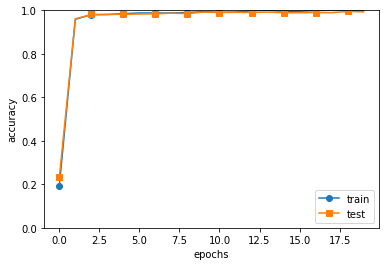

In [8]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 处理花费时间较长的情况下减少数据 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 保存参数
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()